In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as K
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D
import os
from tqdm.notebook import tqdm

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
tf.compat.v1.disable_eager_execution()

# Creates a graph.
a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
c = tf.matmul(a, b)
config = tf.compat.v1.ConfigProto(log_device_placement=True)
config.gpu_options.per_process_gpu_memory_fraction = 0.7
# Creates a session with log_device_placement set to True.
sess = tf.compat.v1.Session(config=config)
# Runs the op.
print(sess.run(c))

print(tf.__version__)
print(tf.test.is_gpu_available())

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce GTX 1660 Ti, pci bus id: 0000:04:00.0, compute capability: 7.5

[[22. 28.]
 [49. 64.]]
2.5.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


In [3]:
# Import Noisy Images
bad_frames = 'imgData/bad_frames'
noisy_frames = []
for file in sorted(os.listdir(bad_frames)):
    if any(extension in file for extension in ['.jpg', 'jpeg', '.png']):
        image = tf.keras.preprocessing.image.load_img(bad_frames + '/' + file, target_size=(128, 128))
        image = tf.keras.preprocessing.image.img_to_array(image).astype('float32') / 255
        noisy_frames.append(image)

noisy_frames = np.array(noisy_frames)

# Import Clean Images
good_frames = 'imgData/good_frames'
clean_frames = []
for file in sorted(os.listdir(good_frames)):
    if any(extension in file for extension in ['.jpg', 'jpeg', '.png']):
        image = tf.keras.preprocessing.image.load_img(good_frames + '/' + file, target_size=(128, 128))
        image = tf.keras.preprocessing.image.img_to_array(image).astype('float32') / 255
        clean_frames.append(image)

clean_frames = np.array(clean_frames)

# Split Images Into Training & Test
round(len(noisy_frames) * 0.8)

# 80% of images to training set
noisy_train = noisy_frames[0:round(len(noisy_frames) * 0.8)]
noisy_test = noisy_frames[round(len(noisy_frames) * 0.8):]
clean_train = clean_frames[0:round(len(clean_frames) * 0.8)]
clean_test = clean_frames[round(len(clean_frames) * 0.8):]

# Autoencoder
autoencoder = tf.keras.models.Sequential()
# Layer 1
autoencoder.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', input_shape=(128, 128, 3)))
autoencoder.add(tf.keras.layers.LeakyReLU(alpha=0.01))
# Layer 3
autoencoder.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same'))
autoencoder.add(tf.keras.layers.BatchNormalization())
autoencoder.add(tf.keras.layers.LeakyReLU(alpha=0.01))
# Layer 4
autoencoder.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), padding='same'))
autoencoder.add(tf.keras.layers.BatchNormalization())
autoencoder.add(tf.keras.layers.LeakyReLU(alpha=0.01))
# Layer 5
autoencoder.add(tf.keras.layers.Conv2D(filters=8, kernel_size=(3, 3), padding='same'))
autoencoder.add(tf.keras.layers.BatchNormalization())
autoencoder.add(tf.keras.layers.LeakyReLU(alpha=0.01))
# Layer 6
autoencoder.add(tf.keras.layers.Conv2D(filters=8, kernel_size=(3, 3), padding='same'))
autoencoder.add(tf.keras.layers.BatchNormalization())
autoencoder.add(tf.keras.layers.LeakyReLU(alpha=0.01))
# Layer 7
autoencoder.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), padding='same'))
autoencoder.add(tf.keras.layers.BatchNormalization())
autoencoder.add(tf.keras.layers.LeakyReLU(alpha=0.01))
# Layer 8
autoencoder.add(tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=(3, 3), padding='same'))
autoencoder.add(tf.keras.layers.BatchNormalization())
autoencoder.add(tf.keras.layers.LeakyReLU(alpha=0.01))
# Layer 9
autoencoder.add(tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), padding='same'))
autoencoder.add(tf.keras.layers.BatchNormalization())
autoencoder.add(tf.keras.layers.LeakyReLU(alpha=0.01))
# Layer 11
autoencoder.add(
    tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=(3, 3), activation='sigmoid', padding='same'))

autoencoder.summary()
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = autoencoder.fit(noisy_train, clean_train, epochs=50, validation_data=(noisy_test, clean_test))

#  Model History
# plt.figure(figsize=(12, 8))
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.legend(['Train', 'Test'])
# plt.title('Binary Crossentropy vs. Epoch (Noise  = 0.1)')
# plt.xlabel('Epoch')
# plt.ylabel('Binary Crossentropy')
# plt.xticks(ticks=history.epoch, labels=history.epoch)
# plt.show()



Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 64)      1792      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      18464     
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 16)      4624      
__________________________________________________

d:\python test\adaptiveMedianFilter\lib\site-packages\tensorflow\python\keras\engine\training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


1749/1749 [==============================] - 14s 8ms/sample - loss: 0.5812 - val_loss: 0.7155
Epoch 2/50
1749/1749 [==============================] - 8s 5ms/sample - loss: 0.5502 - val_loss: 0.6838
Epoch 3/50
1749/1749 [==============================] - 8s 5ms/sample - loss: 0.5436 - val_loss: 0.7336
Epoch 4/50
1749/1749 [==============================] - 8s 5ms/sample - loss: 0.5411 - val_loss: 0.6764
Epoch 5/50
1749/1749 [==============================] - 8s 5ms/sample - loss: 0.5389 - val_loss: 0.6595
Epoch 6/50
1749/1749 [==============================] - 8s 5ms/sample - loss: 0.5376 - val_loss: 0.6299
Epoch 7/50
1749/1749 [==============================] - 8s 5ms/sample - loss: 0.5362 - val_loss: 0.6012
Epoch 8/50
1749/1749 [==============================] - 8s 5ms/sample - loss: 0.5359 - val_loss: 0.5916
Epoch 9/50
1749/1749 [==============================] - 8s 5ms/sample - loss: 0.5347 - val_loss: 0.5693
Epoch 10/50
1749/1749 [==============================] - 8s 5ms/sample - l

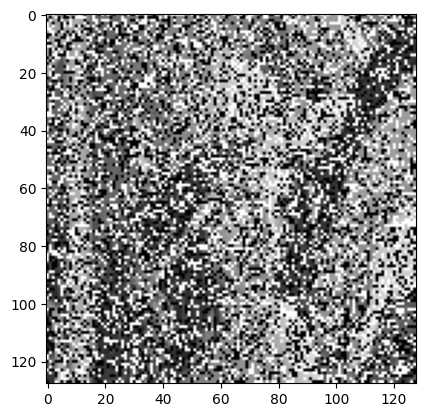

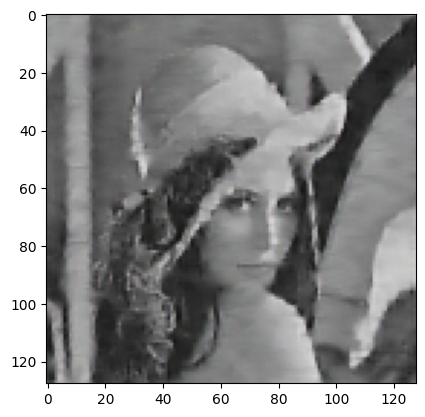

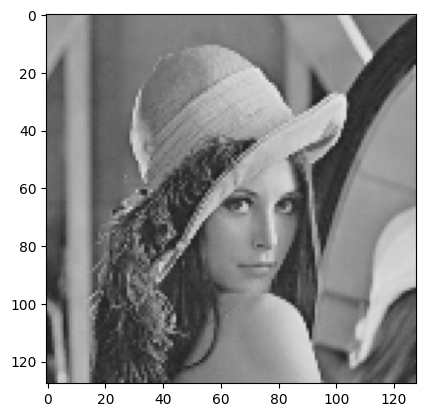

In [6]:
# Test Autoencoder
results = autoencoder.predict(noisy_test)
image = np.random.randint(0, len(noisy_test))
plt.imshow(noisy_frames[2185])
plt.show()

plt.imshow(results[436])
plt.show()

plt.imshow(clean_frames[2185])
plt.show()